In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rv_continuous

In [2]:
seed = 42
np.random.seed(seed)

# mixed device is good for bloch sphere plots
dev = qml.device('default.mixed', wires=1)

class sin_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.sin(theta)
    
# Some unknown distribution
class cos_prob_dist(rv_continuous):
    def _pdf(self, theta):
        return 0.5 * np.cos(theta)
    
class band_prob_dist(rv_continuous):
    def _pdf(self, theta):
        center = np.pi /2
        width = np.pi / 100
        return np.exp(-((theta - center) ** 2) / (2 * width ** 2))
    
# Samples drawn from between 0 and pi
sin_sampler = sin_prob_dist(a=0, b=np.pi)
# dist_sampler = cos_prob_dist(a=0, b=np.pi)
dist_sampler = band_prob_dist(a=0, b=np.pi)

@qml.qnode(dev)
def haar_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = sin_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

@qml.qnode(dev)
def dist_random_unitary():
    phi, omega = 2 * np.pi * np.random.uniform(size=2)
    theta = dist_sampler.rvs()
    qml.Rot(phi, theta, omega, wires=0)
    return qml.state()

num_samples = 1000
dist_samples = [dist_random_unitary() for _ in range(num_samples)]

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

def convert_to_bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    return [ax, ay, az]

distribution_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in dist_samples])

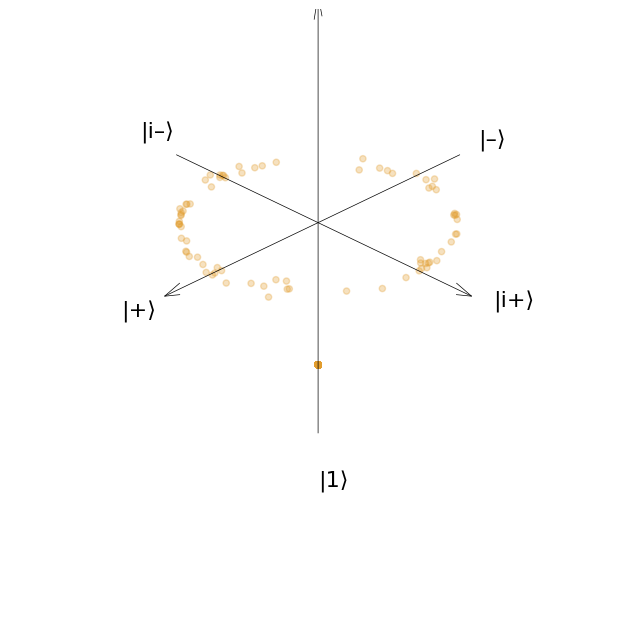

In [3]:
def plot_bloch_sphere(bloch_vectors):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.grid(False)
    ax.set_axis_off()
    ax.view_init(30, 45)
    ax.dist = 7

    x, y, z = np.array([[-1.5,0,0], [0, -1.5, 0], [0, 0, -1.5]])
    u, v, w = np.array([[3,0,0], [0, 3, 0], [0,0,3]])
    ax.quiver(x, y, z, u, v, w, arrow_length_ratio=0.05, color="black", linewidth=0.5)

    ax.text(0, 0, 1.7, r"|0⟩", color="black", fontsize=16)
    ax.text(0, 0, -1.9, r"|1⟩", color="black", fontsize=16)
    ax.text(1.9, 0, 0, r"|+⟩", color="black", fontsize=16)
    ax.text(-1.7, 0, 0, r"|–⟩", color="black", fontsize=16)
    ax.text(0, 1.7, 0, r"|i+⟩", color="black", fontsize=16)
    ax.text(0,-1.9, 0, r"|i–⟩", color="black", fontsize=16)

    ax.scatter(bloch_vectors[:, 0], bloch_vectors[:, 1], bloch_vectors[:, 2], c="#e29d2e", alpha=0.3)
    
plot_bloch_sphere(distribution_bloch_vectors)

(1000, 2, 2) [[-3.38346104e-17+4.11878593e-17j -7.63463433e-01-4.18214983e-01j]
 [ 2.55187797e-17-1.60303063e-17j  3.34549260e-01+3.60966213e-01j]]
(1000, 3) [-0.76346343  0.41821498 -0.33454926]


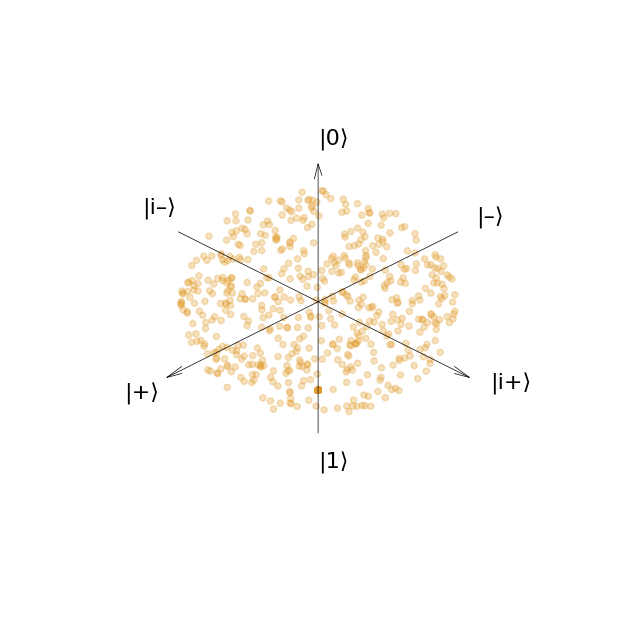

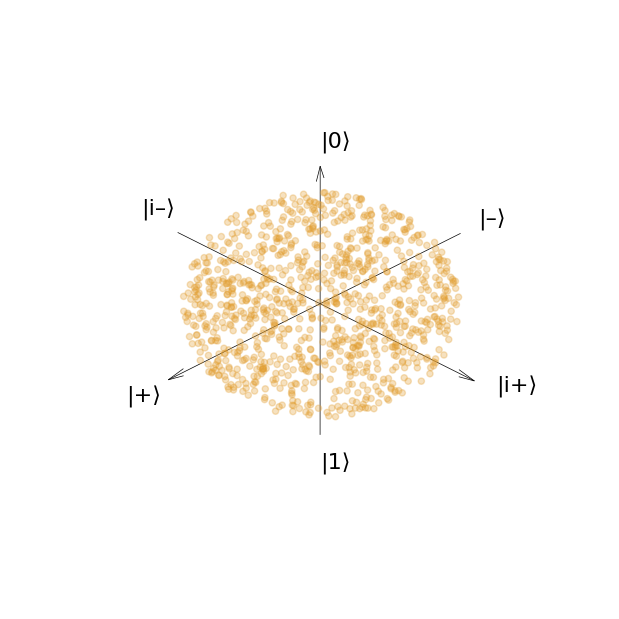

In [4]:
from scipy.stats import unitary_group

def haar_random_unitary(seed=None):
    if seed is not None:
        np.random.seed(seed)
    return unitary_group.rvs(2)

def scramble_state_vectors(state_vectors, seed):
    scrambled_vectors = []

    for i in range(num_samples):
        U = haar_random_unitary()
        
        scrambled_state = np.dot(U, state_vectors[i])
        scrambled_state /= np.linalg.norm(scrambled_state)
        scrambled_vectors.append(scrambled_state)

        # Half way point for Bloch visualization
        if i == num_samples//2:
            scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in np.array(scrambled_vectors)])
            remaining_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in state_vectors[i-1:]])
            half_scrambled_states = np.concatenate((scrambled_bloch_states, remaining_bloch_vectors), axis=0)
            plot_bloch_sphere(half_scrambled_states)

        if seed is not None:
            if i % 4 == 0:
                seed += 1
    return np.array(scrambled_vectors)

scrambled_states = scramble_state_vectors(np.array(dist_samples), seed)
print(scrambled_states.shape, scrambled_states[0])
scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
print(scrambled_bloch_states.shape, scrambled_bloch_states[0])
plot_bloch_sphere(scrambled_bloch_states)

## Denoising ## 

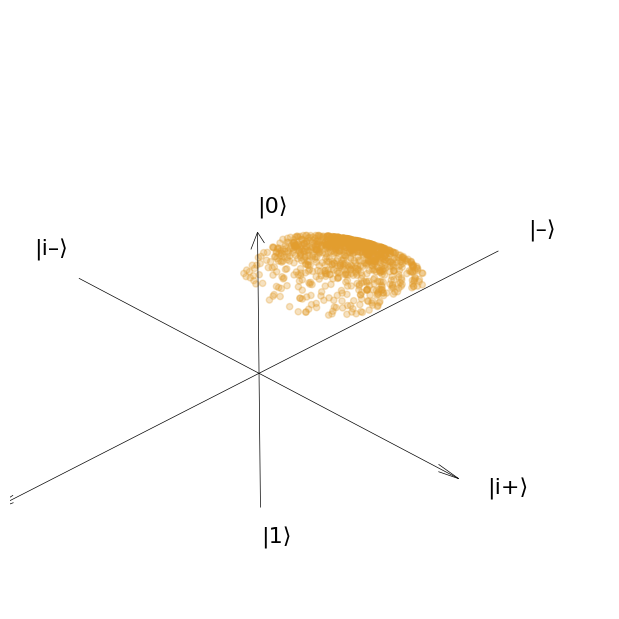

In [6]:
np.random.seed(seed)

def convert_to_state_vector(bloch_vector):
    bloch_vector = np.asarray(bloch_vector)
    if bloch_vector.shape != (3,):
        raise ValueError("Bloch vector must have shape (3,)")
    
    theta = bloch_vector[1]
    phi = bloch_vector[2]

    state_vector = np.array([
        np.cos(theta / 2),
        np.sin(theta / 2) * np.exp(1j * phi)
    ])
    
    return state_vector

@qml.qnode(dev)
def backward_circuit(state, params, n_layers):
    state = normalize_state(convert_to_state_vector(state))
    # state = [[1-0j, 0-0j], [0-0j, 1-0j]]
    # print("Sum of squares ", sum(np.absolute(state) ** 2))
    qml.StatePrep(state, wires=0)
    for l in range(n_layers):
        # qml.RX(params[2*l], wires=0)
        # qml.RY(params[2*l+1], wires=0)
        qml.RX(params[0], wires=0)
        qml.RY(params[1], wires=0)
    return qml.state()

def normalize_state(state):
    norm = np.linalg.norm(state)
    if norm == 0:
        raise ValueError("Norm of the state is zero, cannot normalize")
    return state / norm

# def normalize_complex_arr(a):
#     a_oo = a - a.real.min() - 1j*a.imag.min() # origin offsetted
#     return a_oo/np.abs(a_oo).max()

def backward_denoise(states, params, n_layers):
    denoised_states = []
    for idx, state in enumerate(states):
        denoised_state = backward_circuit(state, params, n_layers)
        denoised_state = normalize_state(denoised_state)
        if not np.allclose(np.sum(np.abs(denoised_state)**2), 1.0):
            raise ValueError(f"Sum of amplitudes-squared does not equal one for state index {idx}")
        denoised_states.append(denoised_state)
    return np.array(denoised_states)

n_layers = 10
params = np.random.uniform(0, np.pi, 2 * n_layers)

denoised_states = backward_denoise(scrambled_bloch_states, params, n_layers)
denoised_bloch_states = np.array([convert_to_bloch_vector(s) for s in denoised_states])
plot_bloch_sphere(denoised_bloch_states)


/Users/shararehsayyad/anaconda3/envs/QML/lib/python3.13/site-packages/pennylane/_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


Epoch 5/5, Cost: 0.8692


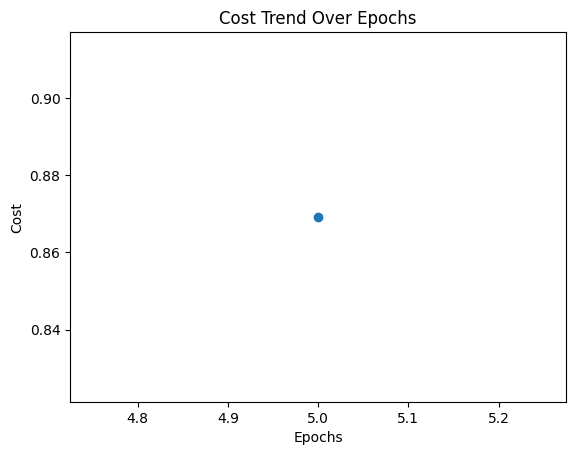

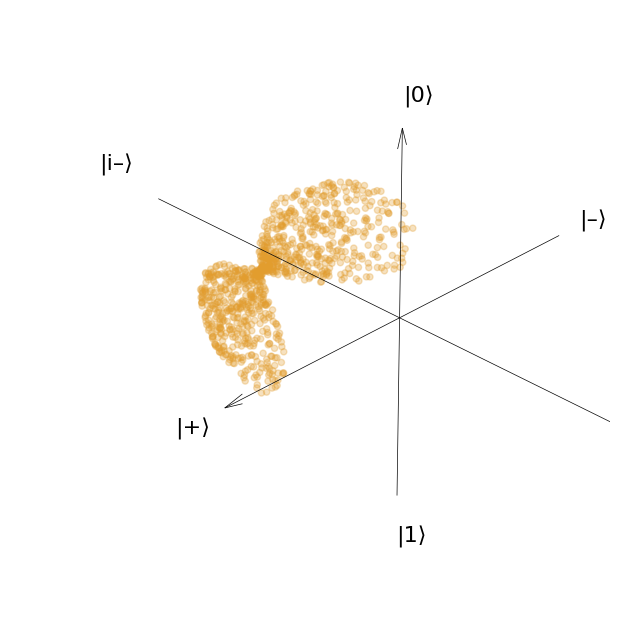

In [7]:
n_layers = 1
def fidelity(state1, state2):
    return np.abs(np.trace(np.dot(state1, state2)))**2

def mmd_distance(denoised_states, target_states):
    m = len(denoised_states)
    n = len(target_states)
    
    f_11 = np.mean([fidelity(denoised_states[i], denoised_states[j]) for i in range(m) for j in range(m)])
    f_22 = np.mean([fidelity(target_states[i], target_states[j]) for i in range(n) for j in range(n)])
    f_12 = np.mean([fidelity(denoised_states[i], target_states[j]) for i in range(m) for j in range(n)])
    
    return f_11 + f_22 - 2 * f_12

def train_denoising(scrambled_states, target_states, n_layers=n_layers, lr=0.001, epochs=5):
    params = np.random.uniform(0, np.pi, 2 * n_layers)
    opt = qml.AdamOptimizer(lr)
    target_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in target_states])
    costs = []

    for epoch in range(epochs):
        # def cost(params):
        #     scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
        #     denoised_states = backward_denoise(scrambled_bloch_states, params, n_layers)
        #     denoise_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in denoised_states])
        #     return np.mean(np.linalg.norm(denoise_bloch_vectors - target_bloch_vectors, axis=1))
        def cost(params):
            scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
            denoised_states = backward_denoise(scrambled_bloch_states, params, n_layers)
            return mmd_distance(denoised_states, target_states)
        
        params = opt.step(cost, params)
        current_cost = cost(params)

        if (epoch + 1) % 5 == 0:
            costs.append(current_cost)
            print(f"Epoch {epoch+1}/{epochs}, Cost: {current_cost:.4f}")

    plt.plot(range(5, epochs + 1, 5), costs, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost Trend Over Epochs')
    plt.show()

    return params

trained_params = train_denoising(scrambled_states, dist_samples)

scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
denoised_states = backward_denoise(scrambled_bloch_states, trained_params, n_layers=n_layers)
denoised_bloch_states = np.array([convert_to_bloch_vector(s) for s in denoised_states])
plot_bloch_sphere(denoised_bloch_states)

Epoch 0/50...
Grad  [ 0.63476419 -0.0159527 ]
Cost: 1.1541
Epoch 1/50...
Grad  [ 0.63560674 -0.01649136]
Cost: 1.1500
Epoch 2/50...
Grad  [ 0.63643887 -0.01703029]
Cost: 1.1460
Epoch 3/50...
Grad  [ 0.63726033 -0.01756941]
Cost: 1.1419
Epoch 4/50...
Grad  [ 0.63807086 -0.01810862]
Cost: 1.1378
Epoch 5/50...
Grad  [ 0.63887019 -0.01864786]
Cost: 1.1337
Epoch 6/50...
Grad  [ 0.63965807 -0.01918702]
Cost: 1.1296
Epoch 7/50...
Grad  [ 0.64043423 -0.01972604]
Cost: 1.1255
Epoch 8/50...
Grad  [ 0.64119838 -0.02026481]
Cost: 1.1214
Epoch 9/50...
Grad  [ 0.64195026 -0.02080326]
Cost: 1.1173
Epoch 10/50...
Grad  [ 0.64268959 -0.0213413 ]
Cost: 1.1131
Epoch 11/50...
Grad  [ 0.64341609 -0.02187884]
Cost: 1.1090
Epoch 12/50...
Grad  [ 0.64412946 -0.02241579]
Cost: 1.1048
Epoch 13/50...
Grad  [ 0.64482944 -0.02295207]
Cost: 1.1006
Epoch 14/50...
Grad  [ 0.64551571 -0.02348759]
Cost: 1.0965
Epoch 15/50...
Grad  [ 0.646188   -0.02402225]
Cost: 1.0923
Epoch 16/50...
Grad  [ 0.64684601 -0.02455596]
Cos

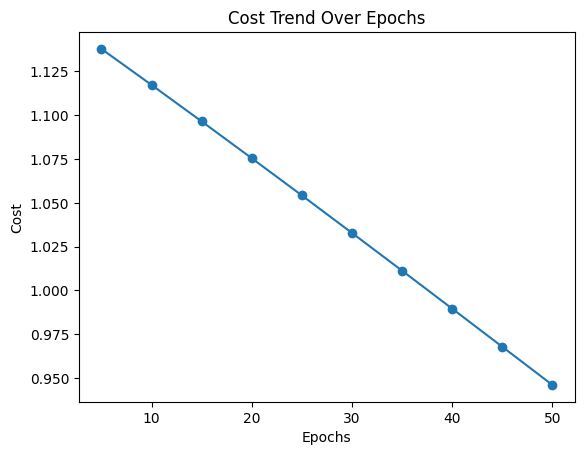

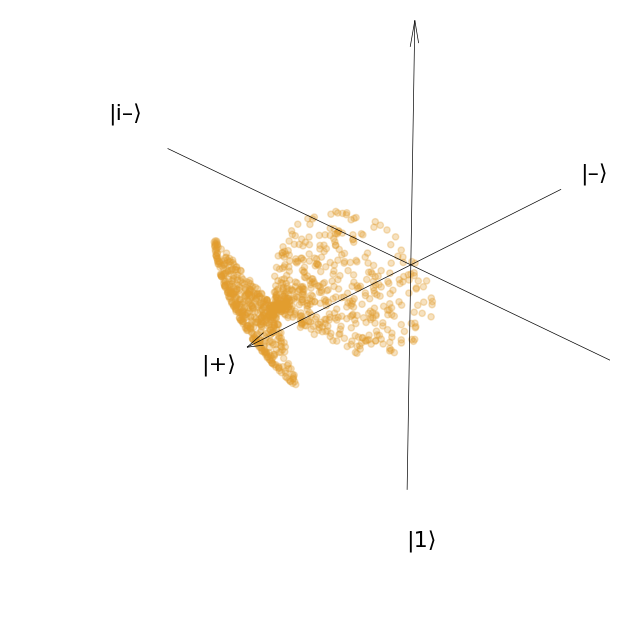

In [ ]:
import autograd.numpy as np
from autograd import grad

np.random.seed(seed)
n_layers = 1
lr = 0.5

def diffusion_error(T, K, n):
    A_K = (np.ceil(np.log2(4 * K)) ** 2) * (K ** 5) * (3.1 / np.log(2))
    return 2 ** (-n * K) * np.exp(-T / A_K)

def measurement_error(F, m, N):
    SE_F = np.sqrt((1 - F) / m)
    return (1 / N**2) * np.sqrt(np.sum(SE_F ** 2))

def generalization_error(L_U, L_S, T, N):
    return (L_U - L_S) / (T * N)


def train_denoising(scrambled_states, target_states, n_layers=n_layers, lr=0.01, epochs=50):
    params = np.random.uniform(0, np.pi, 2 * n_layers)
    # params = qml.numpy.array(params, requires_grad=True)
    opt = qml.AdamOptimizer(lr)
    # opt = qml.GradientDescentOptimizer(stepsize=0.01)
    target_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in target_states])
    costs = []
    N = len(scrambled_states)
    m = 1000
    T = epochs

    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}...")
        def cost(params):
            scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
            denoised_states = backward_denoise(scrambled_bloch_states, params, n_layers)
            denoise_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in denoised_states])
            return np.mean(np.linalg.norm(denoise_bloch_vectors - target_bloch_vectors, axis=1))
        # def cost(params):
        #     scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
        #     denoised_states = backward_denoise(scrambled_bloch_states, params, n_layers)
        #     denoise_bloch_vectors = np.array([convert_to_bloch_vector(s) for s in denoised_states])
            
        #     E_diff = diffusion_error(T, K=1, n=len(target_states[0]))
        #     F = np.mean([fidelity(denoised_states[i], target_states[i]) for i in range(N)])
        #     E_M = measurement_error(F, m, N)
        #     E_gen = generalization_error(mmd_distance(denoised_states, target_states), mmd_distance(scrambled_states, target_states), T, N)
            
        #     total_error = E_diff + E_M + E_gen
        #     return total_error
        
        def compute_gradient(params, epsilon=1e-1):
            grad = np.zeros_like(params)
            
            for i in range(len(params)):
                params_plus = params.copy()
                params_plus[i] += epsilon
                cost_plus = cost(params_plus)
                
                params_minus = params.copy()
                params_minus[i] -= epsilon
                cost_minus = cost(params_minus)
                
                grad[i] = (cost_plus - cost_minus) / (2 * epsilon)
            
            return grad
        
        def gradient_descent_step(params, lr):
            grad = compute_gradient(params)
            print("Grad ", grad)
            params -= lr * grad
            return params
                
        # params = opt.step(cost, params)
        params = gradient_descent_step(params, lr)
        current_cost = cost(params)
        print(f"Cost: {current_cost:.4f}")

        if (epoch + 1) % 5 == 0:
            costs.append(current_cost)

    plt.plot(range(5, epochs + 1, 5), costs, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.title('Cost Trend Over Epochs')
    plt.show()

    return params

trained_params = train_denoising(scrambled_states, dist_samples)

scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
denoised_states = backward_denoise(scrambled_bloch_states, trained_params, n_layers=n_layers)
denoised_bloch_states = np.array([convert_to_bloch_vector(s) for s in denoised_states])
plot_bloch_sphere(denoised_bloch_states)
# 2238

## Plot the Results ##

[1.17665249 2.98675708 2.29962679 1.8807411  0.49014701 0.49007124
 0.18247505 2.72117262 1.8884585  2.22447561 0.0646681  3.04706167
 2.61519568 0.66708299 0.57121998 0.57618226 0.9558052  1.64857095
 1.3569953  0.91492333]
[1.3569953  0.91492333]


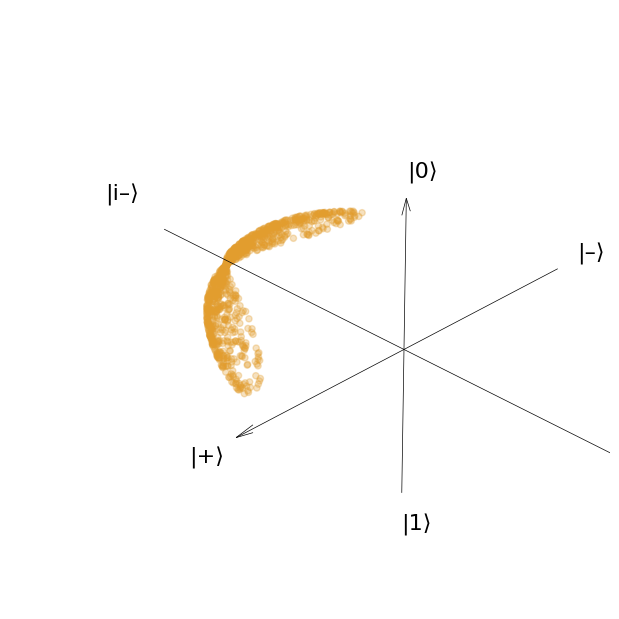

In [ ]:
np.random.seed(seed)

print(params)
trained_params = params[-2:]
print(trained_params)

scrambled_bloch_states = np.array([convert_to_bloch_vector(s) for s in scrambled_states])
denoised_states = backward_denoise(scrambled_bloch_states, trained_params, n_layers=n_layers)
denoised_bloch_states = np.array([convert_to_bloch_vector(s) for s in denoised_states])
plot_bloch_sphere(denoised_bloch_states)